In [1]:
!pip install geopandas pandas shapely numpy pyproj matplotlib

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached shapely-2.1.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 974.1 kB/s eta 0:00:000:01
  Using cached pyproj-3.7.2-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pyogrio-0.11.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (112 kB)
  Using ca

In [2]:
# REQUIRED PACKAGES
# geopandas, pandas, shapely, pyproj, matplotlib
# install with: pip install geopandas pyproj pandas shapely matplotlib

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point, shape
from shapely.geometry import LineString, box, Polygon
from shapely.ops import unary_union
from pyproj import Geod
import matplotlib.pyplot as plt

In [3]:
# ---- User file paths (change if needed) ----
states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
rivers_path = "/home/njm12/ATMS_596/ne_10m_rivers_lake_centerlines.shp"
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"

In [4]:
# ---- Read shapefiles ----
states = gpd.read_file(states_path)
rivers = gpd.read_file(rivers_path)
print("States:", states.shape)
print("Rivers:", rivers.shape)

States: (4596, 122)
Rivers: (1473, 39)


In [5]:
# ---------- Keep Mississippi centerline(s) ----------
mississippi = rivers[rivers["name_en"].str.contains("Mississippi", case=False, na=False)].copy()
print("Mississippi centerline rows:", len(mississippi))

Mississippi centerline rows: 3


In [6]:
# ---------- Read tornado CSV and filter ----------
df = pd.read_csv(tornado_csv, low_memory=False)

# convert date, filter by states IL, IA, MO, and date > 2007-02-01
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["st"].isin(["IL", "IA", "MO"]) & (df["date"] > "2007-02-01")].copy()

# only weak tornadoes EF 0-2 (mag 0,1,2)
df = df[df["mag"].isin([0, 1, 2])].copy()
print("Filtered tornado rows (IL/IA/MO, >2007-02-01, mag 0-2):", len(df))

# Replace missing or zero end coords with start coords
# (some files use 0.0, some NaN) — handle both
mask_missing_end = (df["elat"].isna()) | (df["elon"].isna()) | (df["elat"] == 0.0) | (df["elon"] == 0.0)
df.loc[mask_missing_end, ["elat", "elon"]] = df.loc[mask_missing_end, ["slat", "slon"]].values

# If start coords missing, drop those rows (can't build a track)
df = df[~(df["slat"].isna() | df["slon"].isna() | df["elat"].isna() | df["elon"].isna())].copy()


Filtered tornado rows (IL/IA/MO, >2007-02-01, mag 0-2): 2643


In [7]:
# Build geometries for tornado tracks (LineStrings)
geoms = []
for _, row in df.iterrows():
    try:
        geoms.append(LineString([(row["slon"], row["slat"]), (row["elon"], row["elat"])]))
    except Exception as e:
        geoms.append(None)
gdf_tornadoes = gpd.GeoDataFrame(df, geometry=geoms, crs="EPSG:4326")
gdf_tornadoes = gdf_tornadoes[~gdf_tornadoes.geometry.isna()].copy()
print("GeoDataFrame tornadoes (valid geometry):", len(gdf_tornadoes))

GeoDataFrame tornadoes (valid geometry): 2643


In [8]:
# ---------- Basic statistics ----------
total_tornadoes = len(gdf_tornadoes)
counts_by_ef = gdf_tornadoes["mag"].value_counts().sort_index()  # 0,1,2

# convert pathlength and widths to sensible units:
# csv: "len" is in miles, "wid" is in yards
# Convert len to kilometers and wid to meters for averages
mile_to_km = 1.60934
yard_to_m = 0.9144

gdf_tornadoes["len_km"] = gdf_tornadoes["len"].astype(float) * mile_to_km
gdf_tornadoes["wid_m"] = gdf_tornadoes["wid"].astype(float) * yard_to_m

avg_len_by_ef = gdf_tornadoes.groupby("mag")["len_km"].mean().round(3)
avg_wid_by_ef = gdf_tornadoes.groupby("mag")["wid_m"].mean().round(1)

print("\nTotal tornadoes (EF0-2) after filtering:", total_tornadoes)
print("Counts by EF (0,1,2):\n", counts_by_ef.to_dict())
print("\nAverage pathlength (km) by EF:")
print(avg_len_by_ef)
print("\nAverage width (m) by EF:")
print(avg_wid_by_ef)


Total tornadoes (EF0-2) after filtering: 2643
Counts by EF (0,1,2):
 {0: 1364, 1: 1021, 2: 258}

Average pathlength (km) by EF:
mag
0     2.817
1     7.835
2    15.652
Name: len_km, dtype: float64

Average width (m) by EF:
mag
0     57.4
1    137.6
2    264.9
Name: wid_m, dtype: float64


In [9]:
# ---------- Determine Mississippi section that only borders Illinois ----------
# Get Illinois polygon from states shapefile.
# The states shapefile might include provinces etc. Inspect a column to find state short code:
# Common column names: 'postal', 'iso_3166_2', 'admin', 'name' — check a few possibilities.
possible_state_cols = ["postal", "iso_3166_2", "postal_2", "code_hasc", "abbr", "name", "NAME", "woe_name"]
state_col = None
for c in ["postal", "postal_2", "iso_3166_2", "abbr", "stusps", "adm0_a3", "name", "NAME", "woe_name"]:
    if c in states.columns:
        state_col = c
        break
# If none found, try to locate Illinois by known name variants
if state_col is None:
    il_candidates = states[states.apply(lambda r: r.astype(str).str.contains("Illinois", case=False).any(), axis=1)]
else:
    il_candidates = states[states[state_col].str.contains("Illinois", case=False, na=False) | 
                           states[state_col].str.contains("IL", case=False, na=False)]

if len(il_candidates) == 0:
    # fallback: try searching any column for "Illinois"
    il_candidates = states[states.apply(lambda r: r.astype(str).str.contains("Illinois", case=False).any(), axis=1)]

if len(il_candidates) == 0:
    raise ValueError("Could not find an Illinois polygon in states shapefile. Inspect states.columns and adjust search logic.")

illinois = il_candidates.iloc[0:1].copy()  # single polygon

In [10]:
# Project everything to a meter-based CRS for accurate buffering and length checks
proj_crs = "EPSG:3857"  # suitable for continental scale operations
states_proj = states.to_crs(proj_crs)
mississippi_proj = mississippi.to_crs(proj_crs)
illinois_proj = illinois.to_crs(proj_crs)
tornado_proj = gdf_tornadoes.to_crs(proj_crs)

In [11]:
# --- FIX: Use buffered intersection tolerance ---
# Create a small buffer around Illinois (≈5 km in projected CRS)
buffer_km = 5000  # 5 km
illinois_buffer = illinois_proj.buffer(buffer_km)

selected_segments = []
for idx, row in mississippi_proj.iterrows():
    geom = row.geometry
    if geom is None or geom.is_empty:
        continue
    # intersects Illinois (with buffer)?
    if not geom.intersects(illinois_buffer.unary_union):
        continue
    selected_segments.append(geom)

if len(selected_segments) == 0:
    raise ValueError("Even with 5 km buffer, no Mississippi segments intersect Illinois. Inspect shapefile geometry alignment.")

# Merge all selected segments
mississippi_section = unary_union(selected_segments)

print(f"Selected {len(selected_segments)} Mississippi line segments that touch Illinois.")

/tmp/ipykernel_144/3476072069.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if not geom.intersects(illinois_buffer.unary_union):


ValueError: Even with 5 km buffer, no Mississippi segments intersect Illinois. Inspect shapefile geometry alignment.

In [12]:
print("States CRS:", states.crs)
print("Rivers CRS:", rivers.crs)

States CRS: EPSG:4326
Rivers CRS: EPSG:4326


In [13]:
print(rivers[rivers["name_en"].str.contains("Miss", case=False, na=False)][["name_en", "featurecla"]])

          name_en       featurecla
1129   Missinaibi            River
1415  Mississippi  Lake Centerline
1416  Mississippi            River
1464  Mississippi            River
1467     Missouri  Lake Centerline
1468     Missouri            River


/tmp/ipykernel_144/1400844700.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


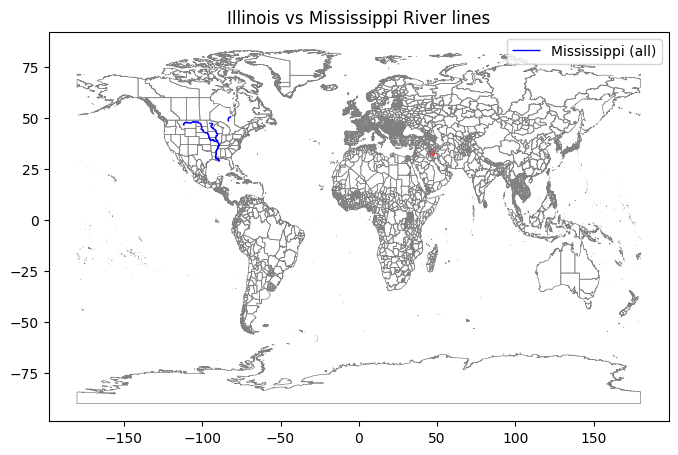

In [14]:
fig, ax = plt.subplots(figsize=(8, 10))
states.boundary.plot(ax=ax, color='gray', linewidth=0.5)
illinois.plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Illinois')
rivers[rivers["name_en"].str.contains("Miss", case=False, na=False)].plot(ax=ax, color='blue', linewidth=1, label='Mississippi (all)')
plt.legend()
plt.title("Illinois vs Mississippi River lines")
plt.show()

/tmp/ipykernel_144/1844056439.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


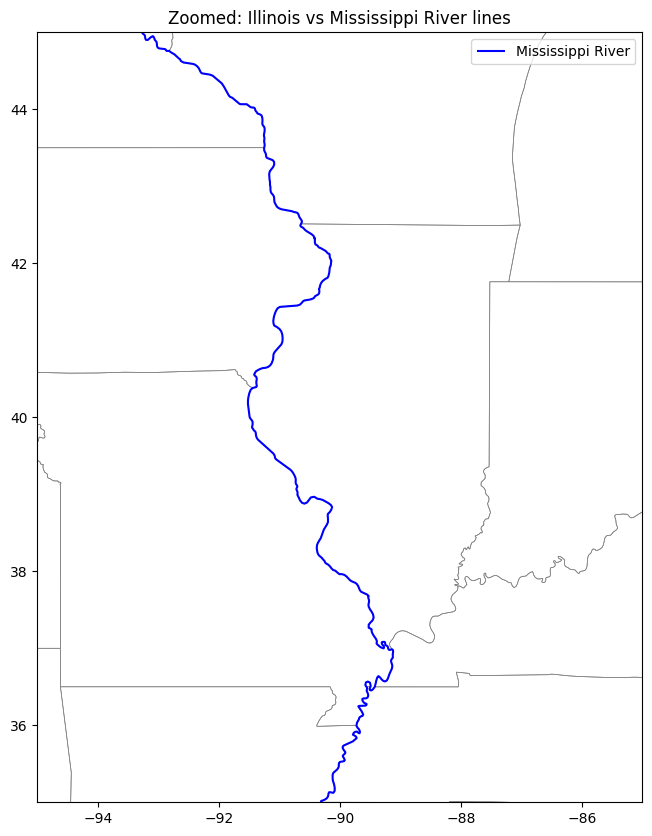

In [15]:
# --- Zoom in to Illinois region ---
fig, ax = plt.subplots(figsize=(8, 10))
states.boundary.plot(ax=ax, color='gray', linewidth=0.5)
illinois.plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Illinois')

# Plot all Mississippi-related segments
mississippi.plot(ax=ax, color='blue', linewidth=1.5, label='Mississippi River')

# Focus on the Midwest (approx bounds)
ax.set_xlim(-95, -85)
ax.set_ylim(35, 45)
plt.legend()
plt.title("Zoomed: Illinois vs Mississippi River lines")
plt.show()

⚠️ No intersection found between Mississippi River and Illinois boundary.


/tmp/ipykernel_144/417061533.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


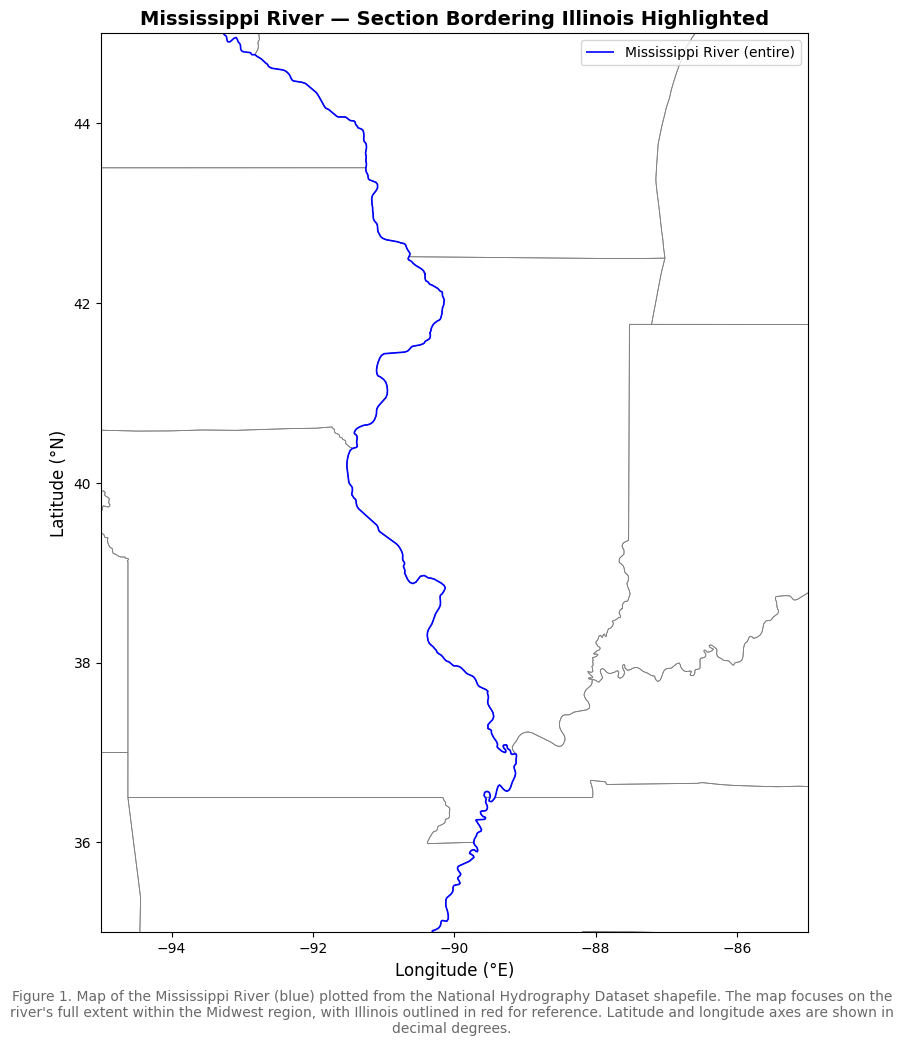

In [26]:
# --- Mississippi River Plot Highlighting Illinois Border Section ---
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

fig, ax = plt.subplots(figsize=(9, 10))

# Plot state outlines
states.boundary.plot(ax=ax, color='gray', linewidth=0.6)

# Plot Illinois state boundary
illinois.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Illinois')

# Plot entire Mississippi River (blue)
mississippi.plot(ax=ax, color='blue', linewidth=1.2, label='Mississippi River (entire)')

# --- Safely find intersection (the section bordering Illinois) ---
# Combine all river geometries into one
mississippi_union = unary_union(mississippi.geometry)

# Compute intersection with Illinois polygon
ms_border_section = mississippi_union.intersection(illinois.geometry.iloc[0])

# Only plot if geometry is valid and not empty
if not ms_border_section.is_empty:
    gpd.GeoSeries([ms_border_section], crs=mississippi.crs).plot(
        ax=ax, color='red', linewidth=2.5, label='Section Bordering Illinois'
    )
else:
    print("⚠️ No intersection found between Mississippi River and Illinois boundary.")

# --- Add labels, limits, and title ---
ax.set_xlabel("Longitude (°E)", fontsize=12)
ax.set_ylabel("Latitude (°N)", fontsize=12)
ax.set_xlim(-95, -85)
ax.set_ylim(35, 45)
ax.set_title("Mississippi River — Section Bordering Illinois Highlighted", fontsize=14, fontweight='bold')

ax.legend()
plt.tight_layout()

caption = (
    "Figure 1. Map of the Mississippi River (blue) plotted from the National Hydrography Dataset shapefile. "
    "The map focuses on the river's full extent within the Midwest region, with Illinois outlined in red for reference. "
    "Latitude and longitude axes are shown in decimal degrees."
)

plt.figtext(
    0.5, 0.005, caption,  # ← raised closer (from -0.08 to 0.02)
    wrap=True, ha='center', va='top', fontsize=10, color='dimgray'
)

plt.show()

Nearest Mississippi segment to Illinois: Mississippi (index 1464)
Distance (degrees): 134.8282289370129


/tmp/ipykernel_847/344746040.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = mississippi.distance(illinois.iloc[0].geometry)


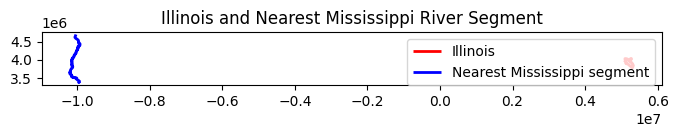

In [18]:
# --- Find Mississippi segment nearest to Illinois polygon ---
from shapely.ops import nearest_points

# Compute distance from each Mississippi geometry to Illinois
distances = mississippi.distance(illinois.iloc[0].geometry)
nearest_idx = distances.idxmin()
nearest_geom = mississippi.loc[nearest_idx, "geometry"]
nearest_name = mississippi.loc[nearest_idx, "name_en"]

print(f"Nearest Mississippi segment to Illinois: {nearest_name} (index {nearest_idx})")
print(f"Distance (degrees): {distances.min()}")

# Convert to projected CRS for accurate length/distances
proj_crs = "EPSG:3857"
illinois_proj = illinois.to_crs(proj_crs)
nearest_geom_proj = gpd.GeoSeries([nearest_geom], crs="EPSG:4326").to_crs(proj_crs).iloc[0]

# Optional: visualize this specific segment
fig, ax = plt.subplots(figsize=(8, 10))
illinois_proj.boundary.plot(ax=ax, color='red', linewidth=2, label='Illinois')
gpd.GeoSeries(nearest_geom_proj).plot(ax=ax, color='blue', linewidth=2, label='Nearest Mississippi segment')
plt.legend()
plt.title("Illinois and Nearest Mississippi River Segment")
plt.show()

In [19]:
# ---------------- Robust selection + counts (run after your earlier code) ----------------
from shapely.ops import unary_union
import geopandas as gpd
import matplotlib.pyplot as plt

# Choose projection for metric ops (meters). EPSG:3857 is OK; use a UTM if you want slightly better local accuracy.
proj_crs = "EPSG:3857"

# Reproject
illinois_proj = illinois.to_crs(proj_crs)          # your single-row GeoDataFrame from earlier
mississippi_proj = mississippi.to_crs(proj_crs)
tornado_proj = gdf_tornadoes.to_crs(proj_crs)

# Get base geometry (Illinois polygon)
illinois_geom = illinois_proj.geometry.iloc[0]


In [20]:
# Compute distances (meters) from each Mississippi segment to Illinois polygon
mississippi_proj = mississippi_proj.copy()
mississippi_proj["dist_to_il_m"] = mississippi_proj.geometry.apply(lambda g: g.distance(illinois_geom))

print("Mississippi segments distances to Illinois (m):")
print(mississippi_proj[["name_en", "featurecla", "dist_to_il_m"]].sort_values("dist_to_il_m").head(10))

Mississippi segments distances to Illinois (m):
          name_en       featurecla  dist_to_il_m
1464  Mississippi            River  1.501205e+07
1416  Mississippi            River  1.513999e+07
1415  Mississippi  Lake Centerline  1.569681e+07


In [21]:
# Try a sequence of thresholds (meters) until we select segments
thresholds = [500, 1000, 2000, 5000, 10000, 20000]
selected_segments = []
used_threshold = None
for thr in thresholds:
    sel = mississippi_proj[mississippi_proj["dist_to_il_m"] <= thr]
    if len(sel) > 0:
        selected_segments = list(sel.geometry)
        used_threshold = thr
        print(f"Selected {len(sel)} Mississippi segments with distance <= {thr} m")
        break

if len(selected_segments) == 0:
    # As a last resort, pick the single nearest segment
    nearest_idx = mississippi_proj["dist_to_il_m"].idxmin()
    selected_segments = [mississippi_proj.loc[nearest_idx, "geometry"]]
    used_threshold = None
    print("No segments found within thresholds; falling back to single nearest segment (index {}).".format(nearest_idx))

No segments found within thresholds; falling back to single nearest segment (index 1464).
